In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.stattools import grangercausalitytests
from hurst import compute_Hc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# from reportlab.pdfgen import canvas
# from reportlab.lib import colors
# from reportlab.lib.pagesizes import letter
# from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
# from reportlab.lib.styles import getSampleStyleSheet
# from reportlab.lib.units import inch

In [3]:
class TradingAnalysis:
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file, index_col=0)

    def plot_price_series(self):
        """
        Plot the price series for each asset.
        """
        plt.figure(figsize=(12, 6))
        for col in self.data.columns:
            plt.plot(self.data[col], label=col)
        plt.title("Price Series")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_distributions(self):
        """
        Plot the distribution of prices for each asset using histograms and density plots.
        """
        for col in self.data.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            sns.histplot(self.data[col], kde=True, ax=ax1)
            ax1.set_title(f"Distribution of {col} Prices")
            ax1.set_xlabel("Price")
            ax1.set_ylabel("Frequency")
            
            sns.kdeplot(self.data[col], ax=ax2)
            ax2.set_title(f"Density Plot of {col} Prices")
            ax2.set_xlabel("Price")
            ax2.set_ylabel("Density")
            
            plt.tight_layout()
            plt.show()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix heatmap for the asset prices.
        """
        corr_matrix = self.data.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Correlation Matrix")
        plt.show()

    def augmented_dickey_fuller_test(self):
        """
        Perform the Augmented Dickey-Fuller test for stationarity on each asset's price series.
        The test checks if the series is stationary or if it has a unit root (non-stationary).
        """
        print("Augmented Dickey-Fuller Tests:")
        for col in self.data.columns:
            adf_result = adfuller(self.data[col])
            print(f"{col}: ADF Statistic = {adf_result[0]}, p-value = {adf_result[1] }")
            if adf_result[1] < 0.05:
                print(f"The price series of {col} is likely stationary.")
            else:
                print(f"The price series of {col} is likely non-stationary.")
            print()

    def hurst_exponent(self):
        """
        Calculate the Hurst Exponent for each asset's price series using the hurst library.
        The Hurst Exponent measures the degree of long-term memory or persistence in a time series.
        A value between 0 and 0.5 indicates mean reversion, while a value between 0.5 and 1 indicates trend persistence.
        """
        print("Hurst Exponents:")
        for col in self.data.columns:
            X = self.data[col].values
            H, _, _ = compute_Hc(X)
            print(f"{col}: Hurst Exponent = {H}")
            if H < 0.5:
                print(f"The price series of {col} exhibits mean reversion.")
            elif H > 0.5:
                print(f"The price series of {col} exhibits trend persistence.")
            else:
                print(f"The price series of {col} is similar to a random walk.")
            print()

    def cointegration_test(self):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        for i in range(len(self.data.columns)):
            for j in range(i+1, len(self.data.columns)):
                coint_result = coint(self.data.iloc[:,i], self.data.iloc[:,j])
                print(f"Pair: {self.data.columns[i]} and {self.data.columns[j]}")
                print(coint_result)
                if coint_result[1] < 0.05:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                else:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                print()

    def granger_causality_test(self):
        """
        Perform Granger Causality tests between pairs of asset price series.
        Granger Causality tests if one time series is useful in predicting another.
        """
        print("Granger Causality Tests:")
        for col1 in self.data.columns:
            for col2 in self.data.columns:
                if col1 != col2:
                    gc_result = grangercausalitytests(self.data[[col1, col2]], maxlag=5, verbose=False)
                    p_values = [gc_result[i+1][0]['ssr_ftest'][1] for i in range(5)]
                    min_p_value = min(p_values)
                    if min_p_value < 0.05:
                        print(f"{col2} Granger-causes {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    else:
                        print(f"No significant Granger Causality found from {col2} to {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    print()

    def predictive_modeling(self):
        """
        Perform predictive modeling on the asset returns using various classification algorithms.
        Visualize the prediction results using confusion matrices and evaluate the performance.
        """
        returns = self.data.pct_change().dropna()

        for col in returns.columns:
            print(f"\nPredictive Modeling for {col}:")
            X = returns.drop(columns=[col]).values[:-1]
            y = np.where(returns[col].values[1:] > 0, 1, 0)

            models = [
                LogisticRegression(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(),
                SVC(kernel='linear'),
                SVC(kernel='rbf'),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
            ]

            for model in models:
                model.fit(X, y)
                y_pred = model.predict(X)
                print(f"\n{type(model).__name__} Results:")
                print(classification_report(y, y_pred))

                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)

                print(f"Accuracy: {accuracy}")
                print(f"Precision: {precision}")
                print(f"Recall: {recall}")
                print(f"F1-score: {f1}")

                print("\nAnalysis:")
                print("- Accuracy measures the overall correctness of predictions.")
                print("- Precision indicates the proportion of true positive predictions among the positive predictions.")
                print("- Recall measures the proportion of actual positive instances that were correctly predicted.")
                print("- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.")

                cm = confusion_matrix(y, y_pred)
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f"{type(model).__name__} Confusion Matrix for {col}")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.show()

    def principal_component_analysis(self):
        """
        Perform Principal Component Analysis (PCA) on the asset returns.
        Visualize the explained variance ratios and principal component loadings.
        """
        returns = self.data.pct_change().dropna()

        pca = PCA()
        pca.fit(returns)

        plt.figure(figsize=(8, 4))
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Scree Plot")
        plt.show()

        loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(self.data.columns))], index=self.data.columns)
        plt.figure(figsize=(8, 6))
        sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Principal Component Loadings")
        plt.show()
    
    

In [5]:
data = pd.read_csv("Case 2 Data 2024.csv", index_col=0)

for i in range(len(data.columns)):
    print(data.iloc[:,i].describe())

count    2520.000000
mean      177.285326
std        51.770933
min        93.796081
25%       137.570246
50%       164.391890
75%       222.040380
max       308.698762
Name: A, dtype: float64
count    2520.000000
mean       80.376852
std        37.583146
min        24.817177
25%        36.019144
50%        87.994365
75%       108.094431
max       175.190038
Name: B, dtype: float64
count    2520.000000
mean      117.843694
std        48.092277
min        53.599809
25%        88.868501
50%       101.869981
75%       127.072792
max       264.505962
Name: C, dtype: float64
count    2520.000000
mean      108.080842
std        34.708912
min        41.384998
25%        86.181791
50%       109.714227
75%       128.728656
max       228.135615
Name: D, dtype: float64
count    2520.000000
mean      137.593250
std        41.294310
min        67.380585
25%       102.010623
50%       136.149367
75%       169.636480
max       237.034966
Name: E, dtype: float64
count    2520.000000
mean      165.44379

In [ ]:

def cointegration_test(new_data):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        glob = 0
        for n in range(10000):
            data = new_data.sample(frac=1)
            coint_num = 0
            for i in range(len(data.columns)):
                for j in range(i+1, len(data.columns)):
                    coint_result = coint(data.iloc[:,i], data.iloc[:,j])
                    # print(f"Pair: {data.columns[i]} and {data.columns[j]}")
                    # print(coint_result)
                    if coint_result[1] < 0.05:
                        coint_num += 1
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                    else:
                        pass
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                    print()
            glob += coint_num
            #print(f"Number of cointegrated pairs: {coint_num}")
            #print("\n\n")
        print(f"Average number of cointegrated pairs: {glob/10000}")

cointegration_test(data)


<Axes: >

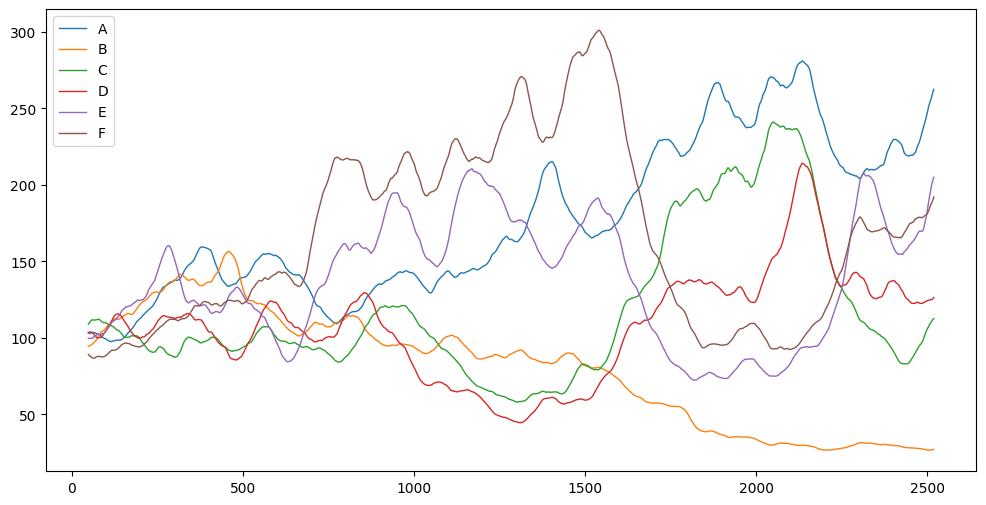

In [26]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("Case 2 Data 2024.csv", index_col=0)

# # Plot the data
# data.plot(figsize=(12, 6), linewidth=1)

# Plot the data with smoothened lines
window = 50
data_smooth = data.rolling(window=window).mean()  # Adjust the window size as needed
data_smooth.plot(figsize=(12, 6), linewidth=1)



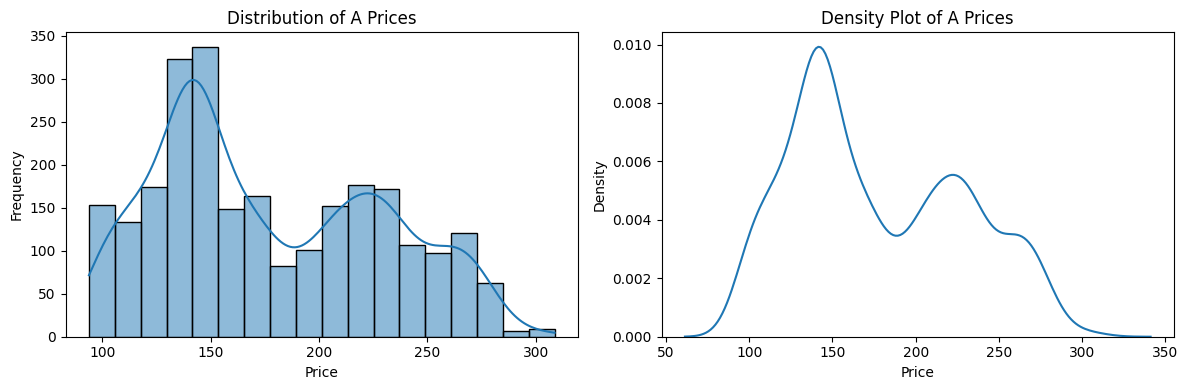

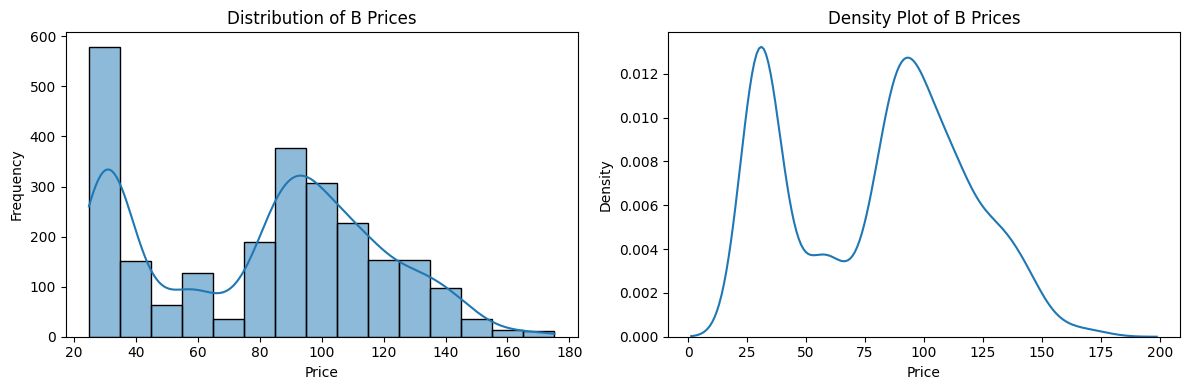

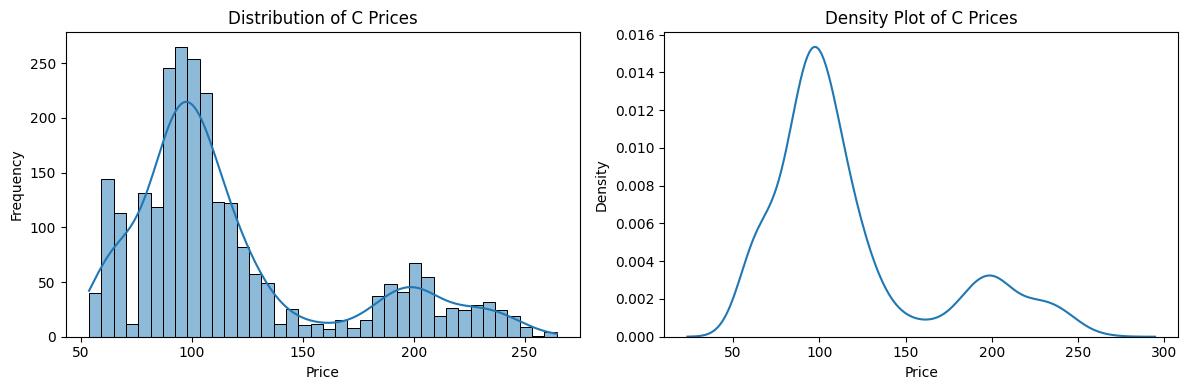

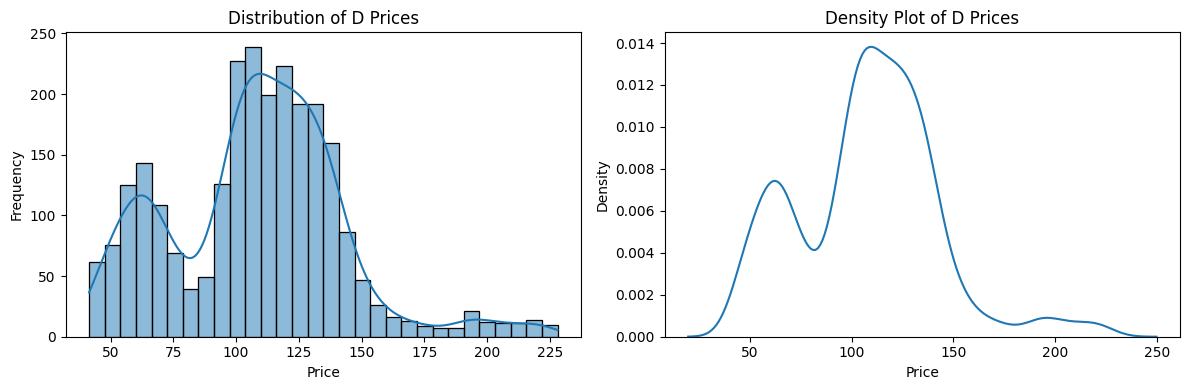

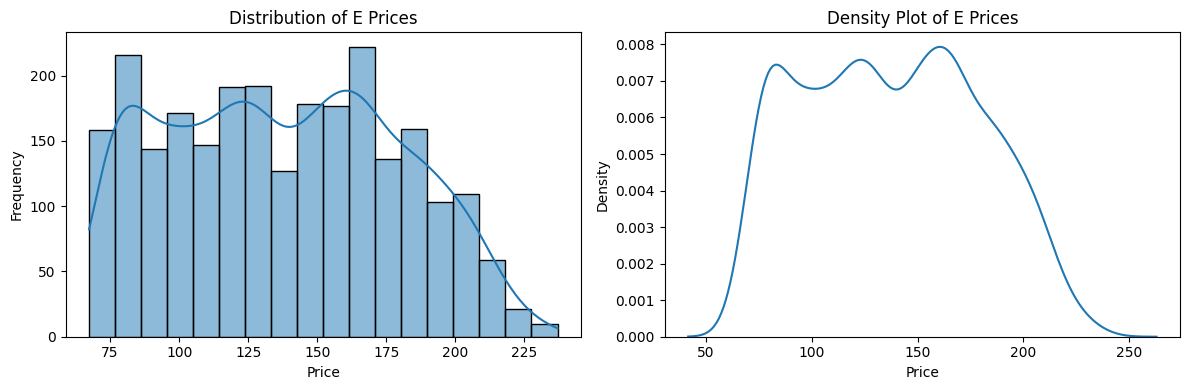

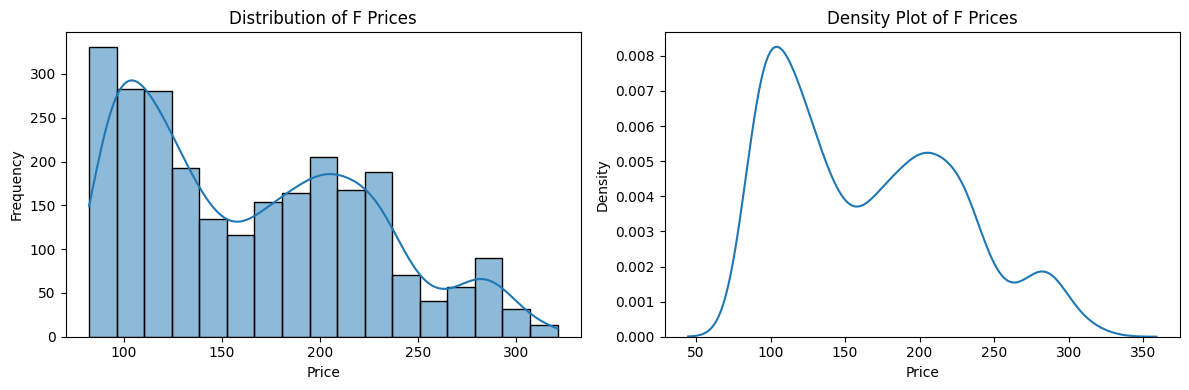

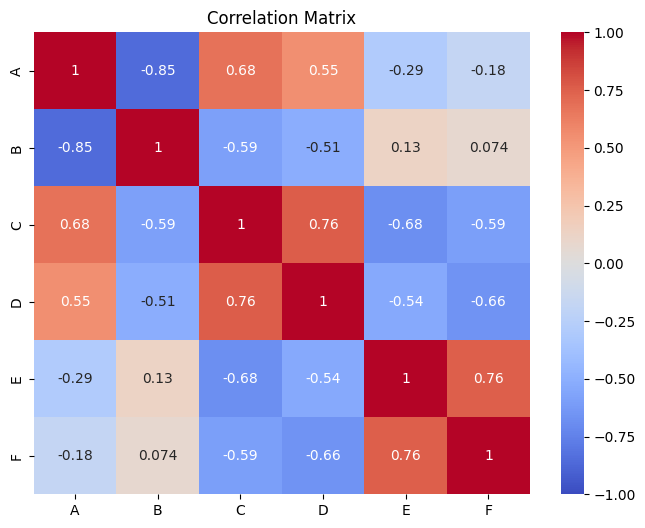

Augmented Dickey-Fuller Tests:
A: ADF Statistic = -1.1560927641668437, p-value = 0.6921927763036669
The price series of A is likely non-stationary.

B: ADF Statistic = -0.5805295000682599, p-value = 0.8753211482478924
The price series of B is likely non-stationary.

C: ADF Statistic = -1.4253409212084642, p-value = 0.570068889146099
The price series of C is likely non-stationary.

D: ADF Statistic = -1.6719925705349443, p-value = 0.44559743000759117
The price series of D is likely non-stationary.

E: ADF Statistic = -1.381573245830188, p-value = 0.5910775644251026
The price series of E is likely non-stationary.

F: ADF Statistic = -1.676579748074022, p-value = 0.4432178889189003
The price series of F is likely non-stationary.

Hurst Exponents:
A: Hurst Exponent = 0.5284957799217287
The price series of A exhibits trend persistence.

B: Hurst Exponent = 0.5737048685281458
The price series of B exhibits trend persistence.

C: Hurst Exponent = 0.5503079071251081
The price series of C exhib

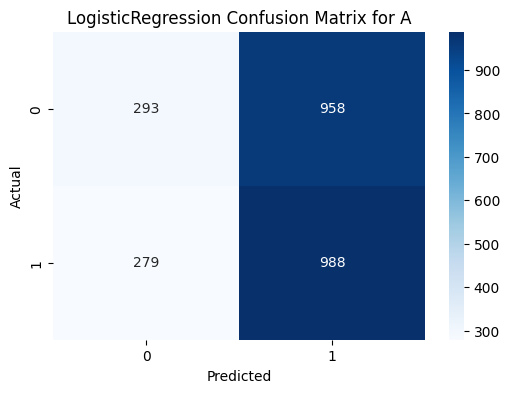


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.47      0.49      1251
           1       0.53      0.58      0.55      1267

    accuracy                           0.53      2518
   macro avg       0.52      0.52      0.52      2518
weighted avg       0.52      0.53      0.52      2518

Accuracy: 0.5250198570293884
Precision: 0.5253390435403283
Recall: 0.5808997632202052
F1-score: 0.5517241379310345

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


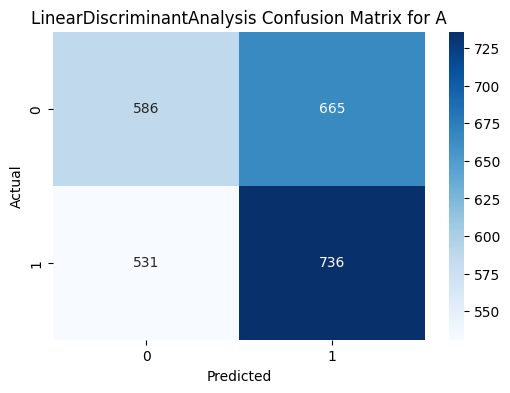


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      1251
           1       0.55      0.52      0.53      1267

    accuracy                           0.55      2518
   macro avg       0.55      0.55      0.55      2518
weighted avg       0.55      0.55      0.55      2518

Accuracy: 0.5464654487688642
Precision: 0.5527426160337553
Recall: 0.5169692186266772
F1-score: 0.534257748776509

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


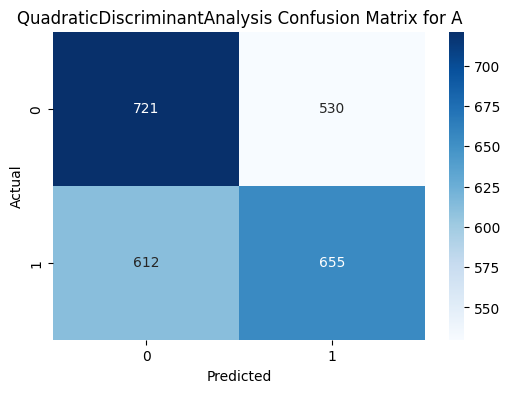


SVC Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1251
           1       0.50      1.00      0.67      1267

    accuracy                           0.50      2518
   macro avg       0.25      0.50      0.33      2518
weighted avg       0.25      0.50      0.34      2518

Accuracy: 0.5031771247021446
Precision: 0.5031771247021446
Recall: 1.0
F1-score: 0.6694848084544254

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


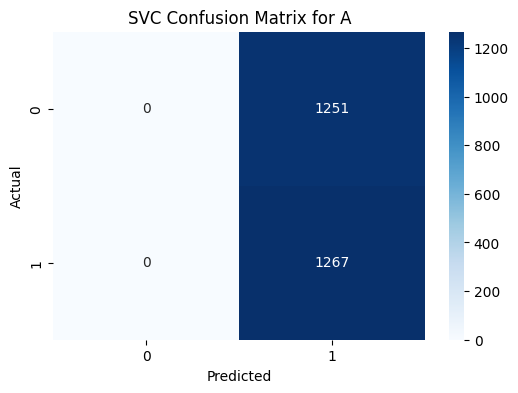


SVC Results:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62      1251
           1       0.61      0.51      0.55      1267

    accuracy                           0.59      2518
   macro avg       0.59      0.59      0.58      2518
weighted avg       0.59      0.59      0.58      2518

Accuracy: 0.5865766481334392
Precision: 0.6070075757575758
Recall: 0.5059194948697711
F1-score: 0.5518725785622041

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


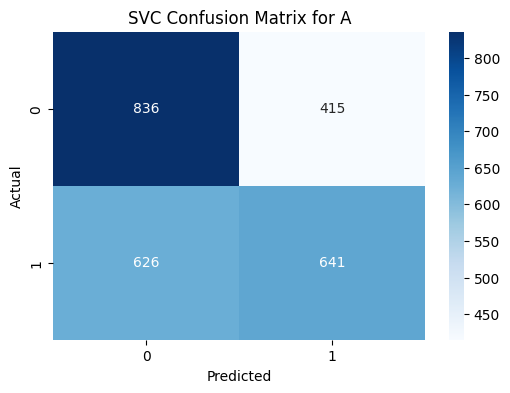


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1251
           1       1.00      1.00      1.00      1267

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


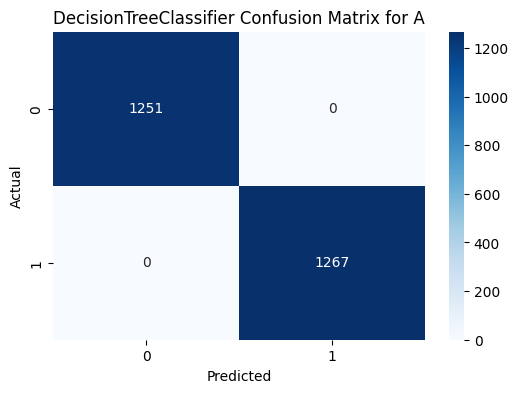


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1251
           1       1.00      1.00      1.00      1267

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


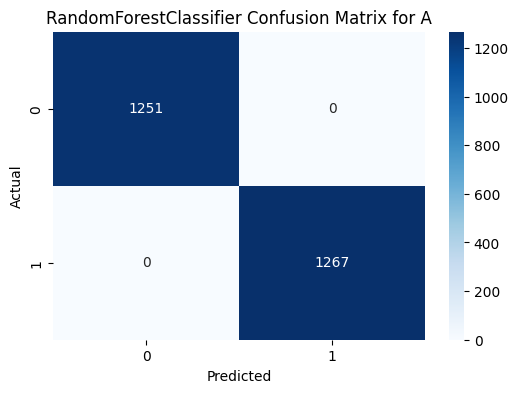


Predictive Modeling for B:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.51      0.98      0.67      1280
           1       0.58      0.03      0.05      1238

    accuracy                           0.51      2518
   macro avg       0.54      0.50      0.36      2518
weighted avg       0.54      0.51      0.37      2518

Accuracy: 0.5119142176330421
Precision: 0.576271186440678
Recall: 0.027463651050080775
F1-score: 0.052428681572860444

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


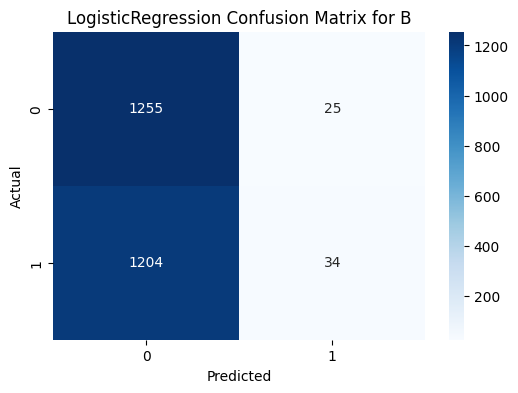


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.74      0.61      1280
           1       0.52      0.29      0.37      1238

    accuracy                           0.52      2518
   macro avg       0.52      0.51      0.49      2518
weighted avg       0.52      0.52      0.49      2518

Accuracy: 0.517474185861795
Precision: 0.516642547033285
Recall: 0.28836833602584816
F1-score: 0.3701399688958009

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


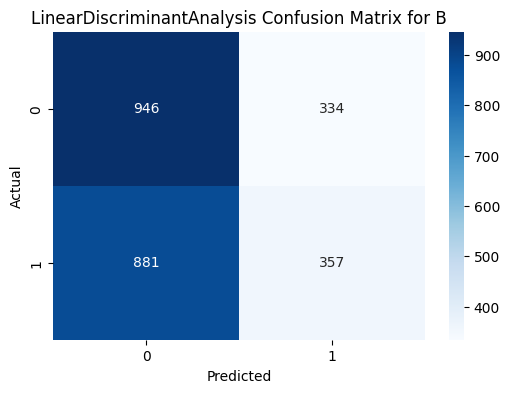


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.54      0.69      0.60      1280
           1       0.54      0.38      0.45      1238

    accuracy                           0.54      2518
   macro avg       0.54      0.54      0.53      2518
weighted avg       0.54      0.54      0.53      2518

Accuracy: 0.5393169181890389
Precision: 0.5446224256292906
Recall: 0.38449111470113084
F1-score: 0.45075757575757575

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


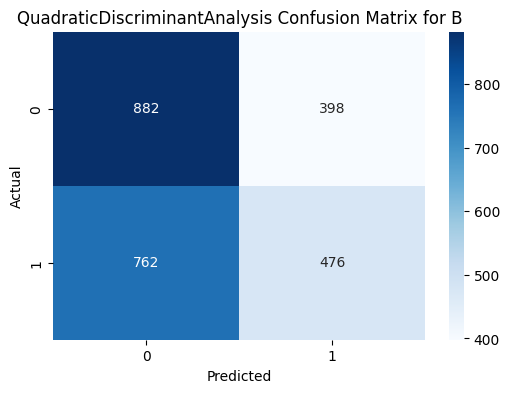


SVC Results:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1280
           1       0.00      0.00      0.00      1238

    accuracy                           0.51      2518
   macro avg       0.25      0.50      0.34      2518
weighted avg       0.26      0.51      0.34      2518

Accuracy: 0.5083399523431295
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


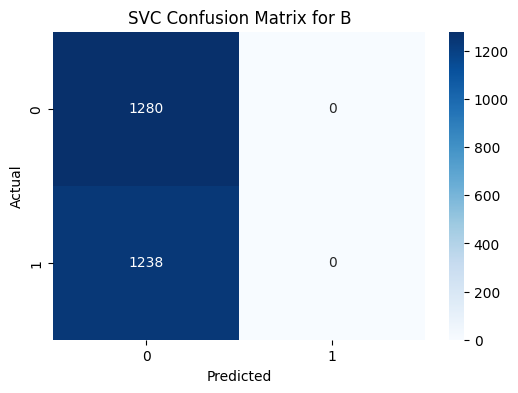


SVC Results:
              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1280
           1       0.62      0.44      0.51      1238

    accuracy                           0.59      2518
   macro avg       0.60      0.59      0.58      2518
weighted avg       0.60      0.59      0.58      2518

Accuracy: 0.5897537728355838
Precision: 0.6160815402038505
Recall: 0.4394184168012924
F1-score: 0.512965582272513

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


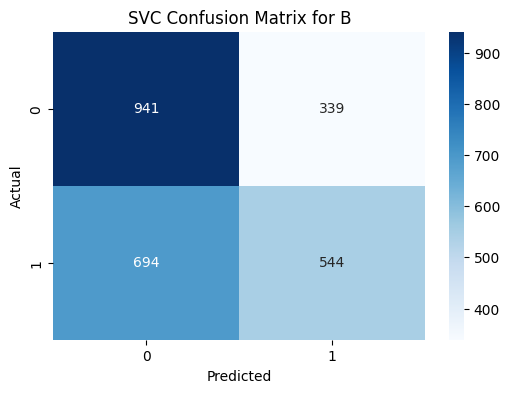


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1280
           1       1.00      1.00      1.00      1238

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


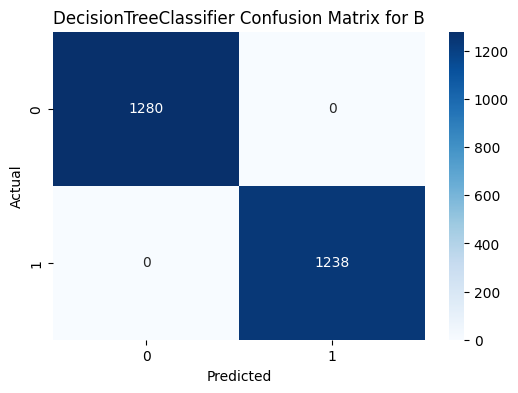


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1280
           1       1.00      1.00      1.00      1238

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


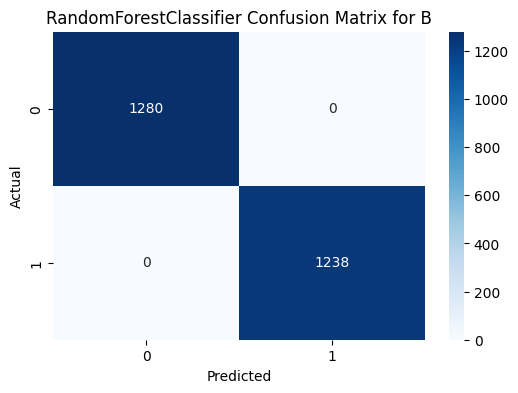


Predictive Modeling for C:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.50      0.94      0.66      1265
           1       0.53      0.07      0.12      1253

    accuracy                           0.51      2518
   macro avg       0.51      0.50      0.39      2518
weighted avg       0.51      0.51      0.39      2518

Accuracy: 0.5055599682287529
Precision: 0.5253164556962026
Recall: 0.06624102154828412
F1-score: 0.11764705882352941

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


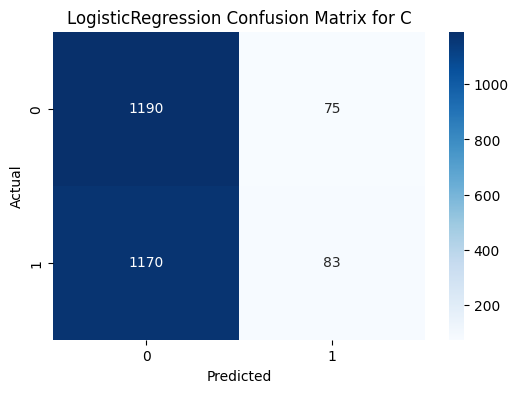


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      1265
           1       0.51      0.45      0.48      1253

    accuracy                           0.51      2518
   macro avg       0.51      0.51      0.51      2518
weighted avg       0.51      0.51      0.51      2518

Accuracy: 0.5146942017474185
Precision: 0.5142332415059688
Recall: 0.44692737430167595
F1-score: 0.47822374039282667

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


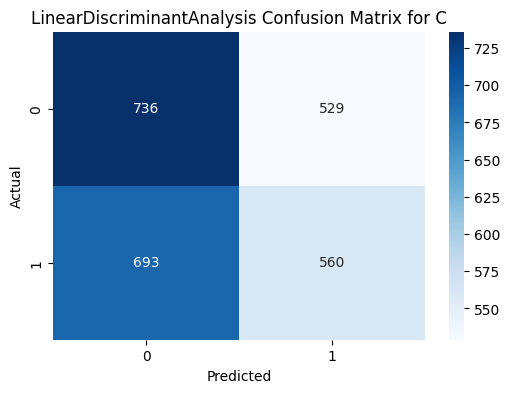


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.49      0.51      1265
           1       0.52      0.55      0.53      1253

    accuracy                           0.52      2518
   macro avg       0.52      0.52      0.52      2518
weighted avg       0.52      0.52      0.52      2518

Accuracy: 0.5206513105639397
Precision: 0.5171385991058122
Recall: 0.5538707102952913
F1-score: 0.5348747591522158

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


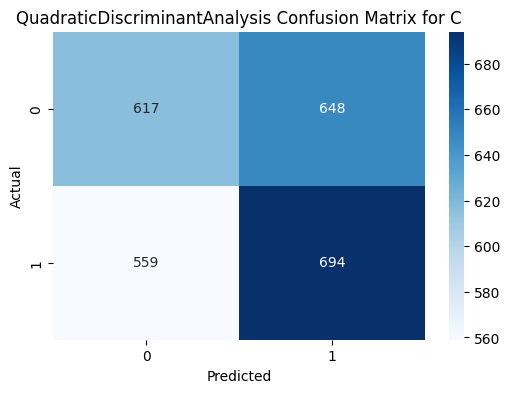


SVC Results:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1265
           1       0.00      0.00      0.00      1253

    accuracy                           0.50      2518
   macro avg       0.25      0.50      0.33      2518
weighted avg       0.25      0.50      0.34      2518

Accuracy: 0.5023828435266084
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


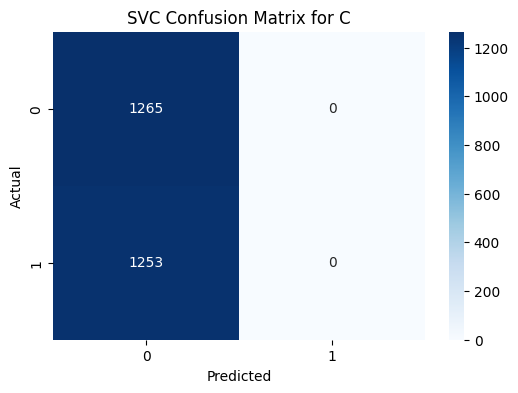


SVC Results:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1265
           1       0.57      0.61      0.59      1253

    accuracy                           0.57      2518
   macro avg       0.57      0.57      0.57      2518
weighted avg       0.57      0.57      0.57      2518

Accuracy: 0.5718824463860207
Precision: 0.5650557620817844
Recall: 0.6065442936951316
F1-score: 0.5850654349499615

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


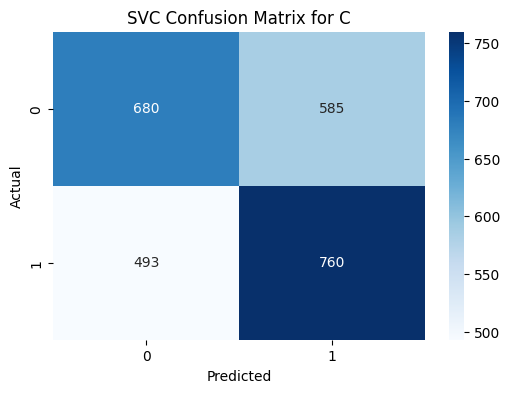


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1265
           1       1.00      1.00      1.00      1253

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


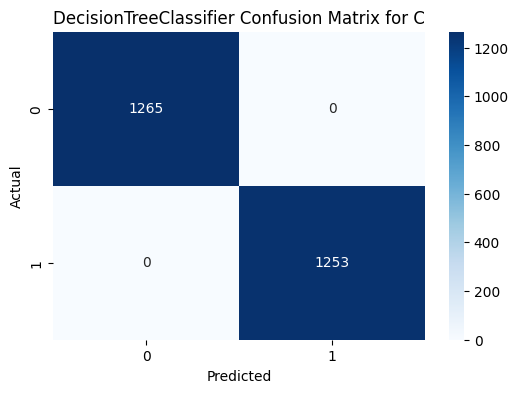


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1265
           1       1.00      1.00      1.00      1253

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


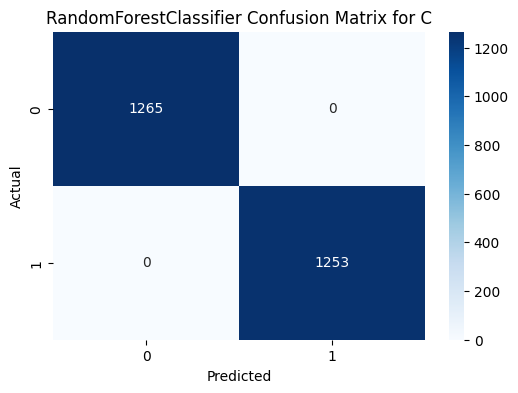


Predictive Modeling for D:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.51      0.43      0.46      1257
           1       0.51      0.59      0.55      1261

    accuracy                           0.51      2518
   macro avg       0.51      0.51      0.51      2518
weighted avg       0.51      0.51      0.51      2518

Accuracy: 0.5103256552819698
Precision: 0.5095108695652174
Recall: 0.5947660586835845
F1-score: 0.5488474204171241

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


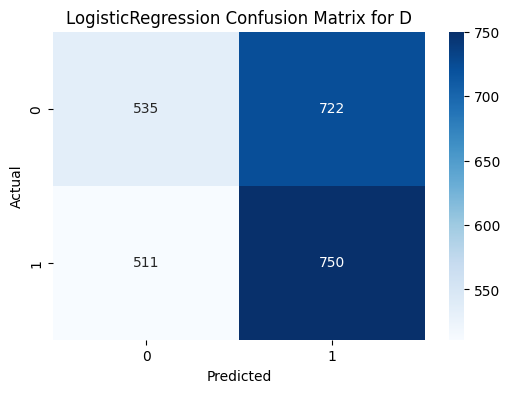


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1257
           1       0.52      0.54      0.53      1261

    accuracy                           0.52      2518
   macro avg       0.52      0.52      0.52      2518
weighted avg       0.52      0.52      0.52      2518

Accuracy: 0.5198570293884035
Precision: 0.5199081163859112
Recall: 0.5384615384615384
F1-score: 0.5290222049084534

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


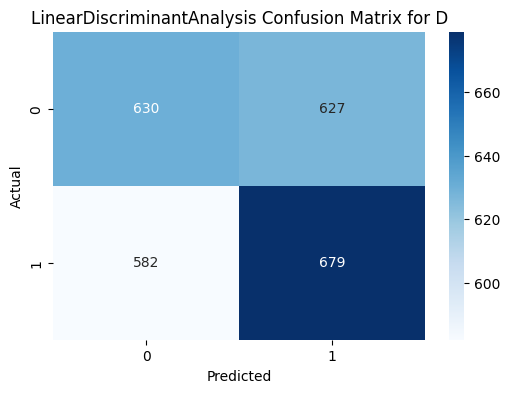


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      1257
           1       0.54      0.57      0.56      1261

    accuracy                           0.54      2518
   macro avg       0.54      0.54      0.54      2518
weighted avg       0.54      0.54      0.54      2518

Accuracy: 0.5416997617156474
Precision: 0.5398956002982849
Recall: 0.5741475019825535
F1-score: 0.5564950038431975

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


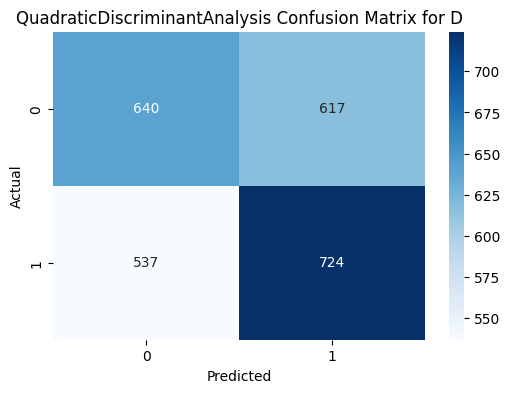


SVC Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1257
           1       0.50      1.00      0.67      1261

    accuracy                           0.50      2518
   macro avg       0.25      0.50      0.33      2518
weighted avg       0.25      0.50      0.33      2518

Accuracy: 0.5007942811755361
Precision: 0.5007942811755361
Recall: 1.0
F1-score: 0.6673723207197672

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


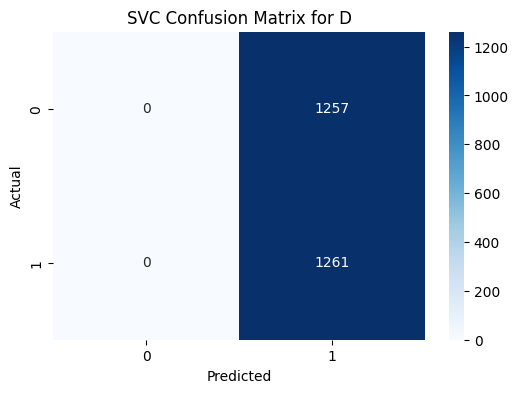


SVC Results:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56      1257
           1       0.57      0.60      0.58      1261

    accuracy                           0.57      2518
   macro avg       0.57      0.57      0.57      2518
weighted avg       0.57      0.57      0.57      2518

Accuracy: 0.573868149324861
Precision: 0.571320182094082
Recall: 0.5971451229183188
F1-score: 0.5839472663823188

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


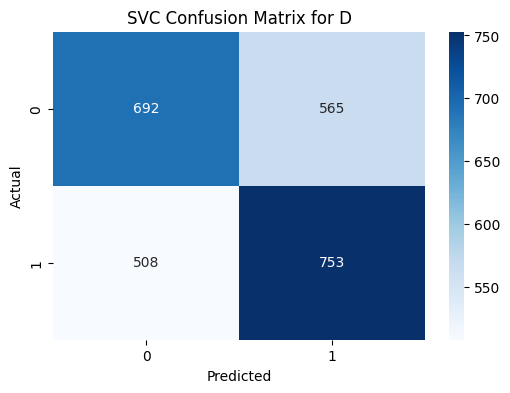


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1261

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


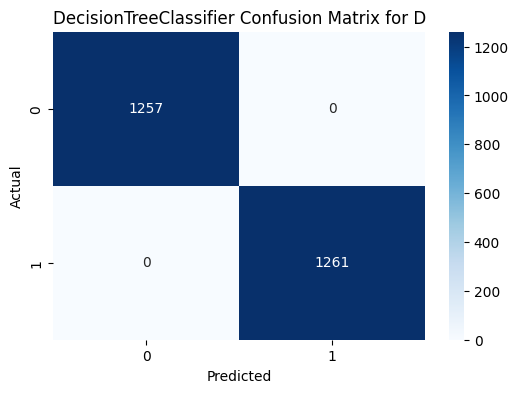


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1261

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


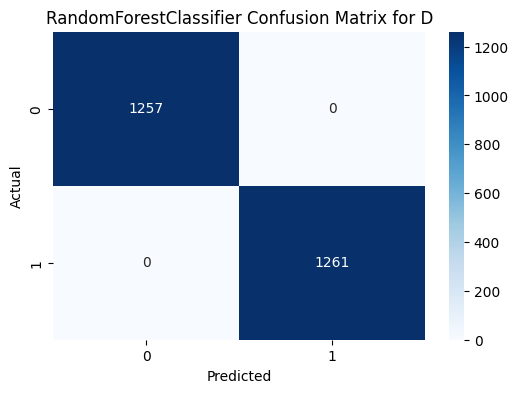


Predictive Modeling for E:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.33      0.00      0.01      1234
           1       0.51      0.99      0.67      1284

    accuracy                           0.51      2518
   macro avg       0.42      0.50      0.34      2518
weighted avg       0.42      0.51      0.35      2518

Accuracy: 0.5083399523431295
Precision: 0.5091779728651237
Recall: 0.9937694704049844
F1-score: 0.6733509234828496

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


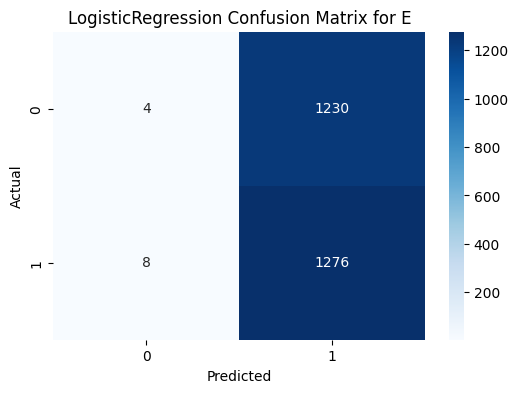


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      1234
           1       0.52      0.66      0.58      1284

    accuracy                           0.52      2518
   macro avg       0.52      0.52      0.51      2518
weighted avg       0.52      0.52      0.51      2518

Accuracy: 0.5182684670373312
Precision: 0.5218730745532963
Recall: 0.6596573208722741
F1-score: 0.5827313381492948

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


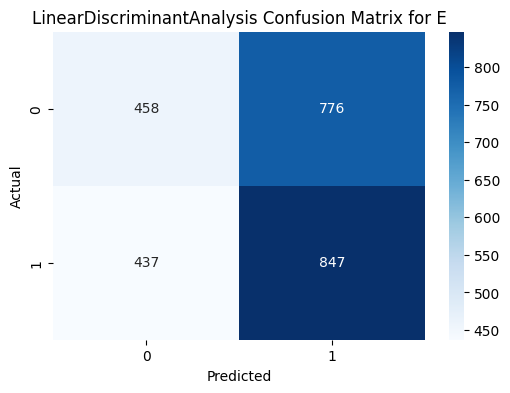


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1234
           1       0.54      0.55      0.55      1284

    accuracy                           0.53      2518
   macro avg       0.53      0.53      0.53      2518
weighted avg       0.53      0.53      0.53      2518

Accuracy: 0.5329626687847498
Precision: 0.5412213740458015
Recall: 0.5521806853582555
F1-score: 0.5466461063993832

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


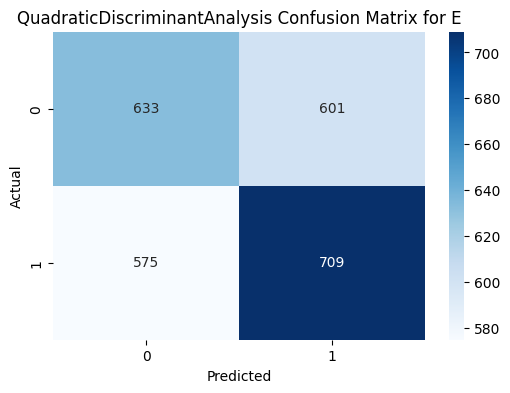


SVC Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1234
           1       0.51      1.00      0.68      1284

    accuracy                           0.51      2518
   macro avg       0.25      0.50      0.34      2518
weighted avg       0.26      0.51      0.34      2518

Accuracy: 0.5099285146942018
Precision: 0.5099285146942018
Recall: 1.0
F1-score: 0.6754339821146765

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


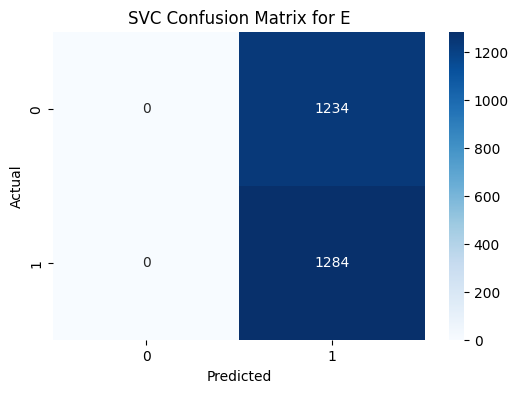


SVC Results:
              precision    recall  f1-score   support

           0       0.59      0.54      0.57      1234
           1       0.59      0.64      0.62      1284

    accuracy                           0.59      2518
   macro avg       0.59      0.59      0.59      2518
weighted avg       0.59      0.59      0.59      2518

Accuracy: 0.5925337569499602
Precision: 0.5929394812680115
Recall: 0.6409657320872274
F1-score: 0.6160179640718563

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


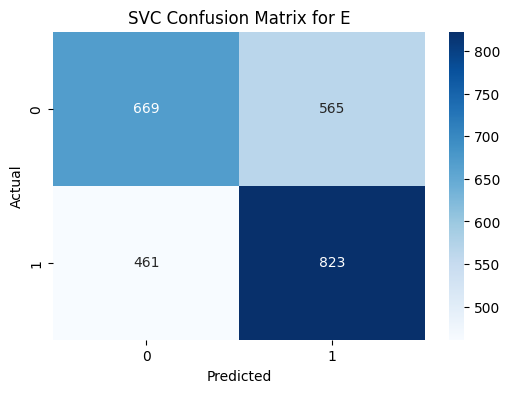


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1234
           1       1.00      1.00      1.00      1284

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


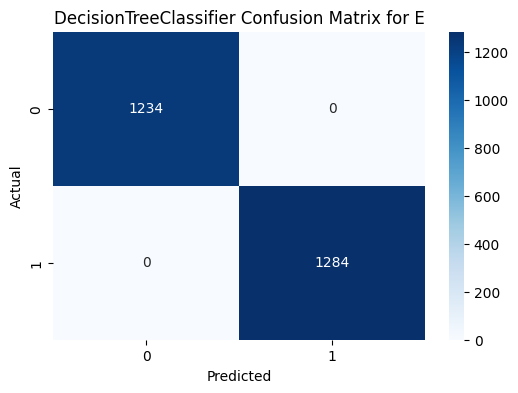


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1234
           1       1.00      1.00      1.00      1284

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


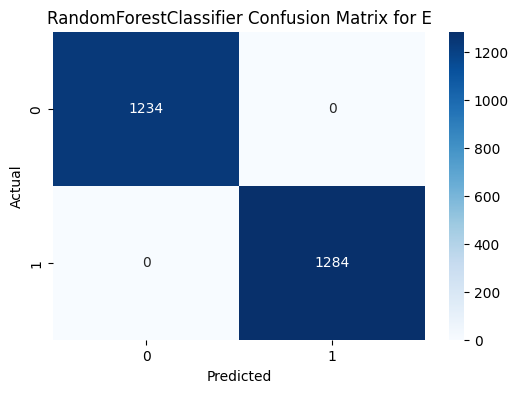


Predictive Modeling for F:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.55      0.23      0.32      1245
           1       0.52      0.81      0.63      1273

    accuracy                           0.52      2518
   macro avg       0.53      0.52      0.48      2518
weighted avg       0.53      0.52      0.48      2518

Accuracy: 0.5246227164416203
Precision: 0.5190763052208835
Recall: 0.812254516889238
F1-score: 0.6333843797856049

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


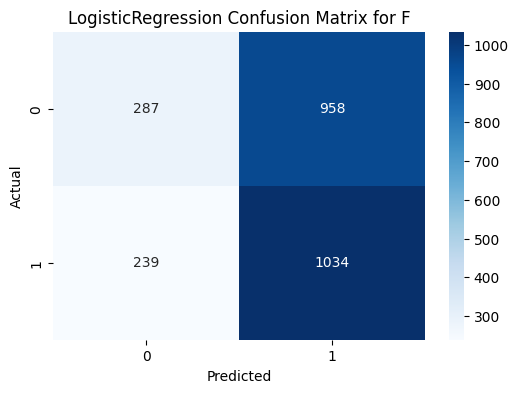


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.53      0.43      0.48      1245
           1       0.53      0.63      0.58      1273

    accuracy                           0.53      2518
   macro avg       0.53      0.53      0.53      2518
weighted avg       0.53      0.53      0.53      2518

Accuracy: 0.5333598093725179
Precision: 0.5324933687002652
Recall: 0.6307934014139828
F1-score: 0.577490111470694

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


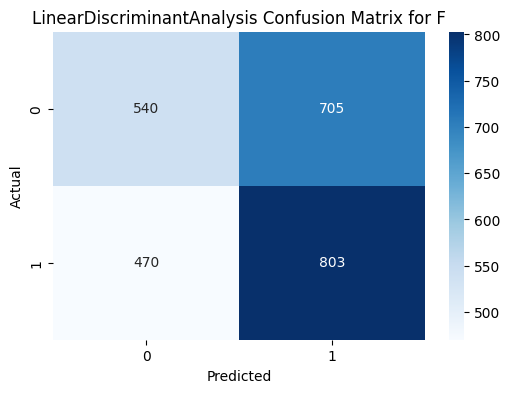


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1245
           1       0.55      0.68      0.61      1273

    accuracy                           0.56      2518
   macro avg       0.56      0.55      0.55      2518
weighted avg       0.56      0.56      0.55      2518

Accuracy: 0.5555996822875298
Precision: 0.5491698595146871
Recall: 0.6755695208169678
F1-score: 0.60584712927087

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


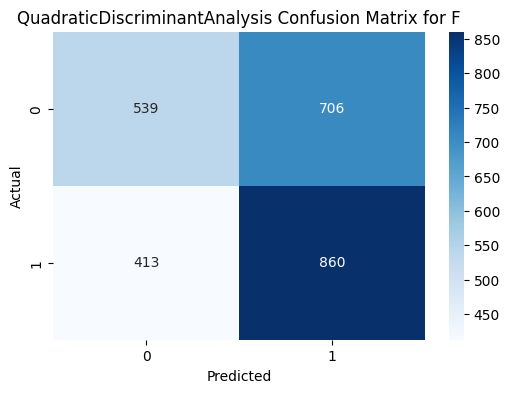


SVC Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1245
           1       0.51      1.00      0.67      1273

    accuracy                           0.51      2518
   macro avg       0.25      0.50      0.34      2518
weighted avg       0.26      0.51      0.34      2518

Accuracy: 0.5055599682287529
Precision: 0.5055599682287529
Recall: 1.0
F1-score: 0.6715906093379056

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


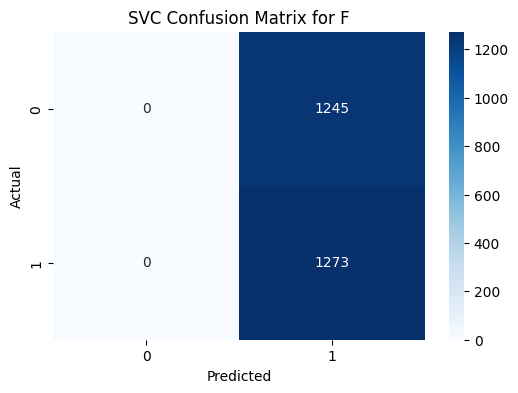


SVC Results:
              precision    recall  f1-score   support

           0       0.63      0.44      0.52      1245
           1       0.58      0.74      0.65      1273

    accuracy                           0.59      2518
   macro avg       0.60      0.59      0.58      2518
weighted avg       0.60      0.59      0.59      2518

Accuracy: 0.5949166004765687
Precision: 0.5769933049300061
Recall: 0.7446975648075412
F1-score: 0.6502057613168725

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


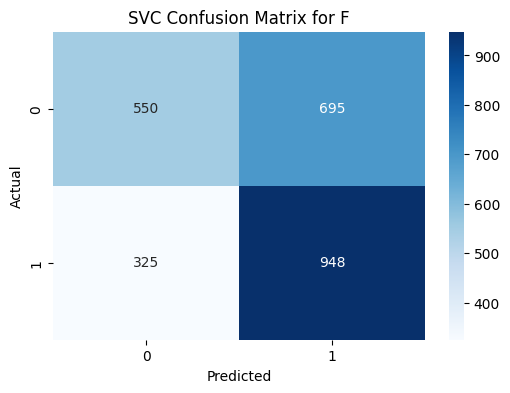


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1245
           1       1.00      1.00      1.00      1273

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


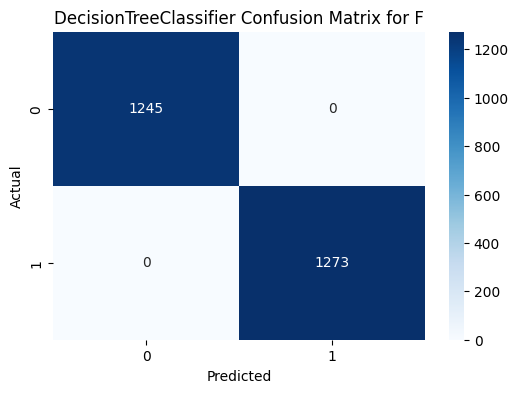


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1245
           1       1.00      1.00      1.00      1273

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


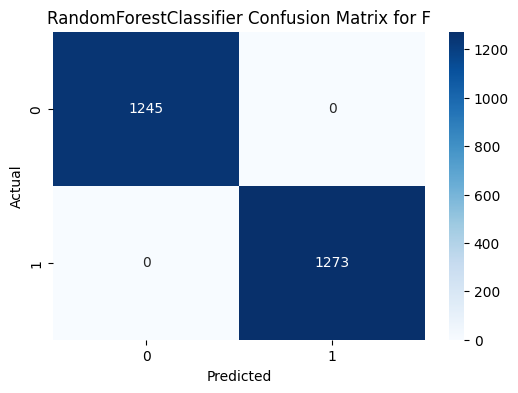

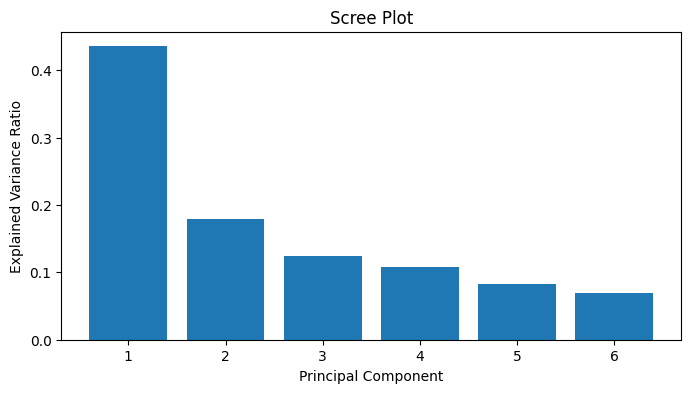

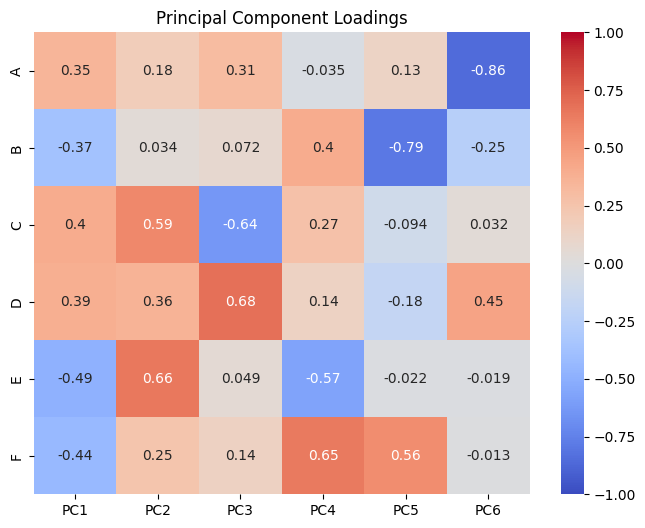

In [29]:
analysis = TradingAnalysis('Case 2 Data 2024.csv')
analysis.plot_distributions()
analysis.plot_correlation_matrix()
analysis.augmented_dickey_fuller_test()
analysis.hurst_exponent()
analysis.cointegration_test()
analysis.granger_causality_test()
analysis.predictive_modeling()
analysis.principal_component_analysis()
